In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint

import os
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [0]:
import glob
import os


result_dir = './result/'
train_lr_dir = '/content/drive/My Drive/MachineLearningFinalProject/data/DIV2K/DIV2K_train_LR_bicubic/X4'
train_hr_dir ='/content/drive/My Drive/MachineLearningFinalProject/data/DIV2K/DIV2K_train_HR'

In [0]:
train_fns = glob.glob(train_hr_dir + '/*.png')
train_ids = [(os.path.basename(train_fn)[0:4]) for train_fn in train_fns]
names = sorted(train_ids)



In [0]:
from skimage import transform 
import cv2
import h5py
Patch_size = 32
def prepare_data(lr_path,hr_path):
    train_fns = glob.glob(train_hr_dir + '/*.png')
    train_ids = [(os.path.basename(train_fn)[0:4]) for train_fn in train_fns]
    train_ids = sorted(train_ids)
    lr = []
    hr = []

    for index in train_ids:
        hr_img = cv2.imread(hr_path + '/' + str(index) + '.png')
        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)[ :, :, 0]
        # two resize operation to produce training data and labels
        lr_img = cv2.imread(lr_path + '/' + index + 'x4.png')
        lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2YCrCb)
        lr_img = transform.resize(lr_img, (lr_img.shape[0]*4, lr_img.shape[1] * 4))[:,:,0]
        shape = hr_img.shape
        Points_x = np.random.randint(0, min(shape[0], shape[1]) - Patch_size,20)
        Points_y = np.random.randint(0, min(shape[0], shape[1]) - Patch_size,20)
        for i in range(10):
            lr_patch = lr_img[Points_x[i]: Points_x[i] + Patch_size, Points_y[i]: Points_y[i] + Patch_size]
            hr_patch = hr_img[Points_x[i]: Points_x[i] + Patch_size, Points_y[i]: Points_y[i] + Patch_size]
            l = np.zeros((1, Patch_size, Patch_size), dtype=np.double)
            h = np.zeros((1, 20, 20), dtype=np.double)
            l[0,:, :] = lr_patch
            h[0, :, :] = hr_patch[6:-6,6:-6]
            lr.append(l)
            hr.append(h)
    lr = np.array(lr, dtype=float)
    hr = np.array(hr, dtype=float)
    return lr, hr

In [0]:
def write_hdf5(lr,hr,output):
    x = np.array(lr)
    y = np.array(hr)
    with h5py.File(output, 'w') as h:
        h.create_dataset('lr', data=x, shape=x.shape)
        h.create_dataset('hr', data=y, shape=y.shape)

In [0]:
lr,hr = prepare_data(train_lr_dir, train_hr_dir) 
write_hdf5(lr, hr, "/content/drive/My Drive/MachineLearningFinalProject/train*4.h5")

In [0]:
import keras.backend as K
import tensorflow as tf
def ssim_loss(y_true, y_pred):
    return 1 - tf.image.ssim(y_true, y_pred,1.0)
def l1_ssim_loss(y_true, y_pred):
    return 0.2 * tf.keras.losses.MAE(y_true, y_pred) + 0.8 * tf.reduce_mean(1 - tf.image.ssim(y_true, y_pred,1.0))
def l2_ssim_loss(y_true, y_pred):
    return 0.2 * tf.keras.losses.MSE(y_true, y_pred) + 0.8 * tf.reduce_mean(1 - tf.image.ssim(y_true, y_pred,1.0))

In [0]:
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred,1)
def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred,1)

def model(loss):
    SRCNN = Sequential()
    SRCNN.add(Conv2D(filters=64, kernel_size=(9, 9), kernel_initializer='glorot_uniform',activation='relu', padding='valid', use_bias=True, input_shape=(None, None,1)))
    SRCNN.add(Conv2D(filters=32, kernel_size=(1, 1), kernel_initializer='glorot_uniform',activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size=(5, 5), kernel_initializer='glorot_uniform',activation='linear', padding='valid', use_bias=True))
    adam = Adam(lr=0.0003)
    SRCNN.compile(optimizer=adam, loss=loss, metrics=['mean_squared_error',psnr,ssim])
    # SRCNN.compile(optimizer=adam, loss=custom_loss, metrics=['mean_squared_error'])
    return SRCNN

In [0]:
l1_loss_SRCNN = model('mean_absolute_error')
l2_loss_SRCNN = model('mean_squared_error')
ssim_loss_SRCNN = model(ssim_loss)
l1_ssim_loss_SRCNN = model(l1_ssim_loss)
l2_ssim_loss_SRCNN = model(l2_ssim_loss)

In [0]:
def read_data(file):
    with h5py.File(file, 'r') as hf:
        lr = np.array(hf.get('lr'))
        lr = np.transpose(lr, (0, 2, 3, 1))
        hr = np.array(hf.get('hr'))
        hr = np.transpose(hr, (0, 2, 3, 1)) / 255
    return lr, hr

In [0]:
lr, hr = read_data('/content/drive/My Drive/MachineLearningFinalProject/train*4.h5')
valid_lr,valid_hr = read_data('/content/drive/My Drive/MachineLearningFinalProject/valid*4.h5')

In [23]:
print("l1_loss")
history_l1_loss_SRCNN =  l1_loss_SRCNN.fit(lr, hr, batch_size=128, epochs=500, verbose=0, validation_data=(valid_lr, valid_hr))
print("l2_loss")
history_l2_loss_SRCNN =l2_loss_SRCNN.fit(lr, hr, batch_size=128, epochs=500, verbose=0, validation_data=(valid_lr, valid_hr))
print("ssim_loss")
history_ssim_loss_SRCNN = ssim_loss_SRCNN.fit(lr, hr, batch_size=128, epochs=500, verbose=0, validation_data=(valid_lr, valid_hr))
print("l1_ssim_loss")
history_l1_ssim_loss_SRCNN = l1_ssim_loss_SRCNN.fit(lr, hr, batch_size=128, epochs=500, verbose=0, validation_data=(valid_lr, valid_hr))
print("L2_ssim_loss")
history_l2_ssim_loss_SRCNN = l2_ssim_loss_SRCNN.fit(lr, hr, batch_size=128, epochs=500, verbose=0, validation_data=(valid_lr, valid_hr))


l1_loss
l2_loss
ssim_loss
l1_ssim_loss
L2_ssim_loss


In [0]:
l1_loss_SRCNN.save('/content/drive/My Drive/MachineLearningFinalProject/model/l1_loss_SRCNN.h5')
l2_loss_SRCNN.save('/content/drive/My Drive/MachineLearningFinalProject/model/l2_loss_SRCNN.h5') 
ssim_loss_SRCNN.save('/content/drive/My Drive/MachineLearningFinalProject/model/ssim_loss_SRCNN.h5') 
l1_ssim_loss_SRCNN.save('/content/drive/My Drive/MachineLearningFinalProject/model/l1_ssim_loss_SRCNN.h5')
l2_ssim_loss_SRCNN.save('/content/drive/My Drive/MachineLearningFinalProject/model/l2_ssim_loss_SRCNN.h5')


In [0]:
import matplotlib.pyplot as plt
def show_mse():
  plt.plot(history_l1_loss_SRCNN.history['val_mean_squared_error'])
  plt.plot(history_l2_loss_SRCNN.history['val_mean_squared_error'])
  plt.plot(history_ssim_loss_SRCNN.history['val_mean_squared_error'])
  plt.plot(history_l1_ssim_loss_SRCNN.history['val_mean_squared_error'])
  plt.plot(history_l2_ssim_loss_SRCNN.history['val_mean_squared_error'])
  plt.title('MSE')
  plt.ylabel('MSE')
  plt.xlabel('Epoch')
  plt.legend(['l1','l2','ssim','l1_ssim','l2_ssim'], loc='upper left')
  # plt.legend(['Train', 'Test'], loc='upper right')
  plt.show()
def show_psnr():
  plt.plot(history_l1_loss_SRCNN.history['val_psnr'])
  plt.plot(history_l2_loss_SRCNN.history['val_psnr'])
  plt.plot(history_ssim_loss_SRCNN.history['val_psnr'])
  plt.plot(history_l1_ssim_loss_SRCNN.history['val_psnr'])
  plt.plot(history_l2_ssim_loss_SRCNN.history['val_psnr'])
  plt.title('PSNR')
  plt.ylabel('PSNR')
  plt.xlabel('Epoch')
  plt.legend(['l1','l2','ssim','l1_ssim','l2_ssim'], loc='upper left')
  # plt.legend(['Train', 'Test'], loc='upper right')
  plt.show()
def show_ssim():
  plt.plot(history_l1_loss_SRCNN.history['val_ssim'])
  plt.plot(history_l2_loss_SRCNN.history['val_ssim'])
  plt.plot(history_ssim_loss_SRCNN.history['val_ssim'])
  plt.plot(history_l1_ssim_loss_SRCNN.history['val_ssim'])
  plt.plot(history_l2_ssim_loss_SRCNN.history['val_ssim'])
  plt.title('SSIM')
  plt.ylabel('SSIM')
  plt.xlabel('Epoch')
  plt.legend(['l1','l2','ssim','l1_ssim','l2_ssim'], loc='upper left')
  # plt.legend(['Train', 'Test'], loc='upper right')
  plt.show()


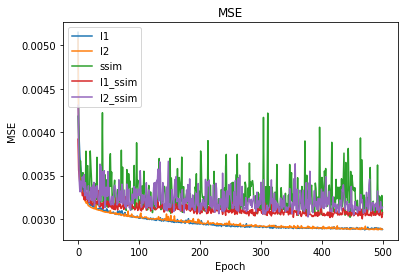

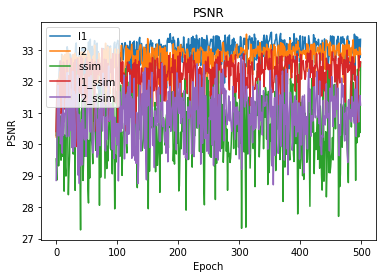

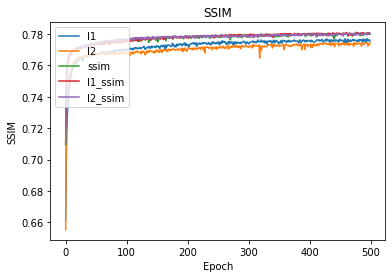

dict_keys(['val_loss', 'val_mean_squared_error', 'val_psnr', 'val_ssim', 'loss', 'mean_squared_error', 'psnr', 'ssim'])

In [26]:
show_mse()
show_psnr()
show_ssim()
history_l1_loss_SRCNN.history.keys()

In [0]:
from keras.models import load_model
dependencies = {
    'psnr': psnr,
    'ssim': ssim,
    'ssim_loss': ssim_loss,
    'l1_ssim_loss':l1_ssim_loss,
    'l2_ssim_loss' : l1_ssim_loss
    
}
l1_loss_SRCNN = load_model('/content/drive/My Drive/MachineLearningFinalProject/model/l1_loss_SRCNN.h5',custom_objects=dependencies)
l2_loss_SRCNN = load_model('/content/drive/My Drive/MachineLearningFinalProject/model/l2_loss_SRCNN.h5',custom_objects=dependencies)
ssim_loss_SRCNN = load_model('/content/drive/My Drive/MachineLearningFinalProject/model/ssim_loss_SRCNN.h5',custom_objects=dependencies)
l1_ssim_loss_SRCNN = load_model('/content/drive/My Drive/MachineLearningFinalProject/model/l1_ssim_loss_SRCNN.h5',custom_objects=dependencies)
l2_ssim_loss_SRCNN = load_model('/content/drive/My Drive/MachineLearningFinalProject/model/l2_ssim_loss_SRCNN.h5',custom_objects=dependencies)

In [27]:
img_test = cv2.imread('/content/drive/My Drive/MachineLearningFinalProject/data/DIV2K_valid_LR_bicubic/X4/0900x4.png')
img_hr_test = cv2.imread('/content/drive/My Drive/MachineLearningFinalProject/data/DIV2K/DIV2K_valid_HR/0900.png')
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2YCrCb)
img_test = transform.resize(img_test, (img_test.shape[0]*4, img_test.shape[1] * 4))
img_test = np.array(img_test * 255, dtype=np.uint8)
img_test_Y = img_test[:,:,0]
img_test = cv2.cvtColor(img_test, cv2.COLOR_YCrCb2BGR)
cv2.imwrite('lr_img.jpg',img_test)

True

In [0]:
import skimage
def predict(model,img_test,img_hr_test,name):
  Y = np.zeros((1, img_test.shape[0], img_test.shape[1], 1), dtype=float)
  Y[0,:,:,0] = img_test_Y / 255
  pred_img = model.predict(Y)
  pred_img[pred_img[:] > 1] = 1
  pred_img[pred_img[:] < 0] = 0
  img_sr_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2YCrCb)
  img_sr_test[6: -6, 6: -6, 0] = pred_img[0, :, :, 0] * 255
  img_sr_test = np.array(img_sr_test, dtype=np.uint8)

  img_sr_test = cv2.cvtColor(img_sr_test, cv2.COLOR_YCrCb2BGR)
  cv2.imwrite(str(name) + '.jpg', img_sr_test)
  # print('MSE bicubic', skimage.metrics.mean_squared_error(img_test,img_hr_test))
  # print('PSNR bicubic', cv2.PSNR(img_test, img_hr_test))
  # print('SSIM bicubic',tf.image.ssim(tf.convert_to_tensor(img_test),tf.convert_to_tensor(img_hr_test),255))
  
  print('MSE SR', skimage.metrics.mean_squared_error(img_sr_test,img_hr_test)/(img_test.shape[0] * img_test.shape[1]))
  print ('PSNR SR', cv2.PSNR(img_sr_test, img_hr_test))
  print('SSIM SR',tf.image.ssim(tf.convert_to_tensor(img_sr_test),tf.convert_to_tensor(img_hr_test),255))


In [29]:
print('MSE bicubic', skimage.metrics.mean_squared_error(img_test,img_hr_test)/(img_test.shape[0] * img_test.shape[1]))
print('PSNR bicubic', cv2.PSNR(img_test, img_hr_test))
print('SSIM bicubic',tf.image.ssim(tf.convert_to_tensor(img_test),tf.convert_to_tensor(img_hr_test),255))

predict(l1_loss_SRCNN,img_test,img_hr_test,'l1')
predict(l2_loss_SRCNN,img_test,img_hr_test,'l2')
predict(ssim_loss_SRCNN,img_test,img_hr_test,'ssim')
predict(l1_ssim_loss_SRCNN,img_test,img_hr_test,'l1+ssim')
predict(l2_ssim_loss_SRCNN,img_test,img_hr_test,'l2+ssim')

MSE bicubic 0.0001224007137253553
PSNR bicubic 23.54213764142664
SSIM bicubic tf.Tensor(0.73006964, shape=(), dtype=float32)
MSE SR 8.10011785191132e-05
PSNR SR 25.33506376703029
SSIM SR tf.Tensor(0.7601494, shape=(), dtype=float32)
MSE SR 7.898768953491118e-05
PSNR SR 25.44438303870195
SSIM SR tf.Tensor(0.76129264, shape=(), dtype=float32)
MSE SR 8.69392502101421e-05
PSNR SR 25.027818239681622
SSIM SR tf.Tensor(0.75730157, shape=(), dtype=float32)
MSE SR 8.606283980469557e-05
PSNR SR 25.07182042011477
SSIM SR tf.Tensor(0.75980306, shape=(), dtype=float32)
MSE SR 8.75193272079999e-05
PSNR SR 24.99893743927805
SSIM SR tf.Tensor(0.7522712, shape=(), dtype=float32)
